In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


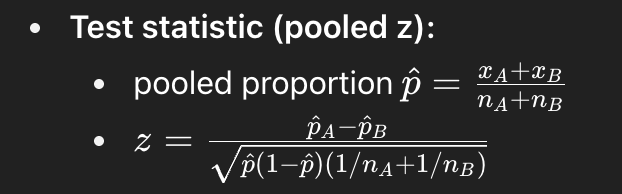

in denominator p^ is used for finding difference in the conversion rate between and b, becasuce we want variance as estimator.(succession rate)

numerator: difference in conversion rate. which is sigma

denominator: it is used for calculating the SE, how much avg the sample statistics differ from the actual statistics.

here we are using cdf, because of its nature, cdf always return value less that its random value x, in this case z. which can later be use for ci.



In [2]:
def two_z_test(na,nb,xa,xb,alternative):
  pooled_val = (pa + pb)/(na+nb)
  se = np.sqrt(pooled_val*(1-pooled_val)*(1/na + 1/nb))
  pa_hat = xa/na
  pb_hat = xb/nb
  z = (pa_hat - pb_hat)/se
  if alternative == 'two_side':
    p_value = 2*(1-norm.cdf(abs(z)))
  elif alternative == 'large':
    p_value = 1- norm.cdf(z)
  elif alternative == 'small':
    p_value = norm.cdf(z)
  else:
    raise ValueError('alternative must be two-sided/larger/smaller')
  return z,p_value


since the click rate is binomial distribution, i use binomial for synthetic data generation with 20% of conversion. b site with 22% of conversions.

In [3]:
np.random.seed(42)
n=100
pa = 0.20
pb = 0.22
a = np.random.binomial(1,pa,size=n)# simulating the data for site a
b = np.random.binomial(1,pb,size=n)
xa,xb = a.sum(),b.sum()
z,p_value = two_z_test(n,n,xa,xb,'two_side')
print('z_test score is ',z,' the p-value is ',p_value)

z_test score is  -9.267937446366163  the p-value is  0.0


since we are using two side test, which is both side test there is a change of getting result z >0 which mean b site is performing good, if z < 0 which mean a is performing good, if we are using large, we are assuming that b is performing well pb > pa,

as for small we are assuming a is performing good, pa > pb.



usually we do type 1 error testing before doing the a/b testing. to see how often that type 1 error occurs.


type 1 error is false positive, i assumes that there is difference but their is none.

tyoe 1 error is calculated with the historical data, here we assumes that historical data is null hypothesis and if pa=pb, both a and b have same type 1 error

in type 1 error we create b data according to a distribution(which replecate the behaviour of a).


In [4]:
def type_1_error_test(pa,pb,n,alpha=0.05,sims=5000,alternative='two_side'):
  rejects =0
  for _ in range(sims):
    a = np.random.binomial(1,pa,size=n)
    b = np.random.binomial(1,pb,size=n)
    z,p_value = two_z_test(n,n,a.sum(),b.sum(),alternative)
    if p_value < alpha:
      rejects +=1
  power = rejects/sims
  return power



errors = type_1_error_test(0.20,0.20,1000)
print('type 1 error is ',errors)
power = type_1_error_test(0.20,0.22,1000)
print('type 1 error',power)

type 1 error is  0.9328
type 1 error 0.9646


In [5]:
sizes = np.arange(200,5001,200)
restuls = []
for size in sizes:
  power = type_1_error_test(0.20,0.22,size)
  restuls.append(power)



In [6]:
exp_df = pd.DataFrame({
    'sample_size':sizes,
    'type_1_error':restuls
})

In [7]:
exp_df

,sample_size,type_1_error
0,200,0.8774
1,400,0.9160
2,600,0.9404
3,800,0.9550
4,1000,0.9648
5,1200,0.9698
6,1400,0.9806
7,1600,0.9800
8,1800,0.9794
9,2000,0.9844


Text(0, 0.5, 'Statistical Power (Prob. of Detecting True Effect)')

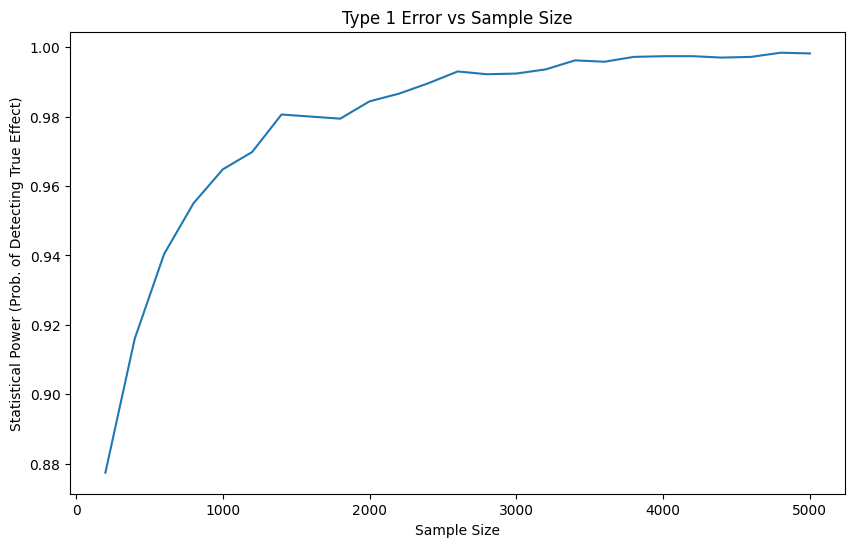

In [8]:
plt.figure(figsize=(10,6))
plt.plot(exp_df['sample_size'],exp_df['type_1_error'])
plt.title('Type 1 Error vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Statistical Power (Prob. of Detecting True Effect)')

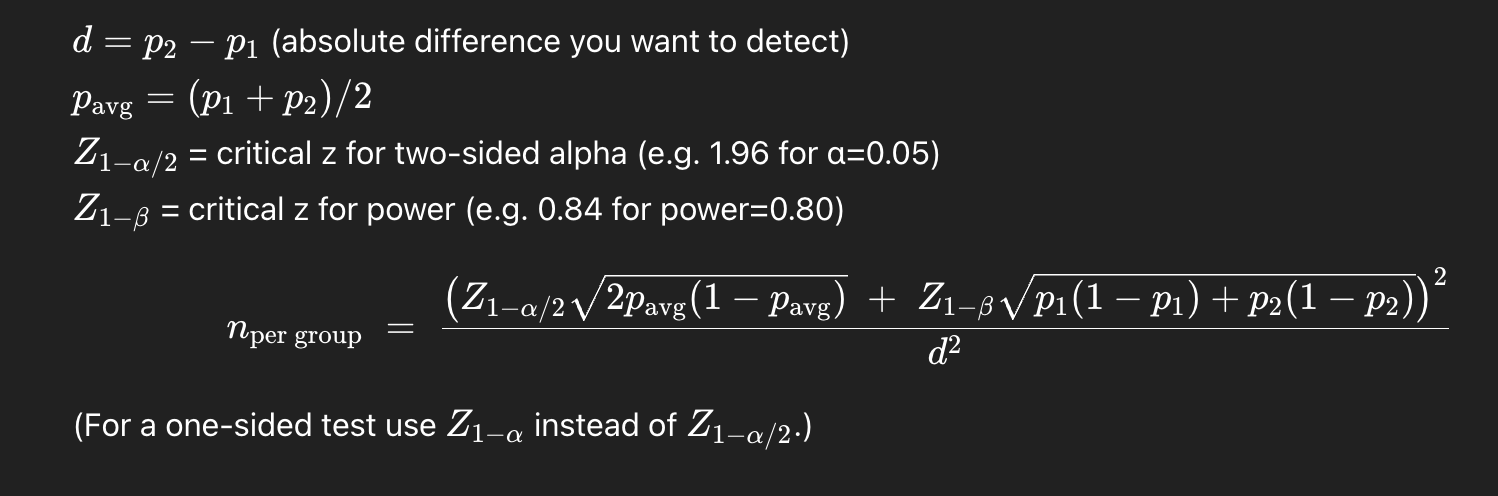

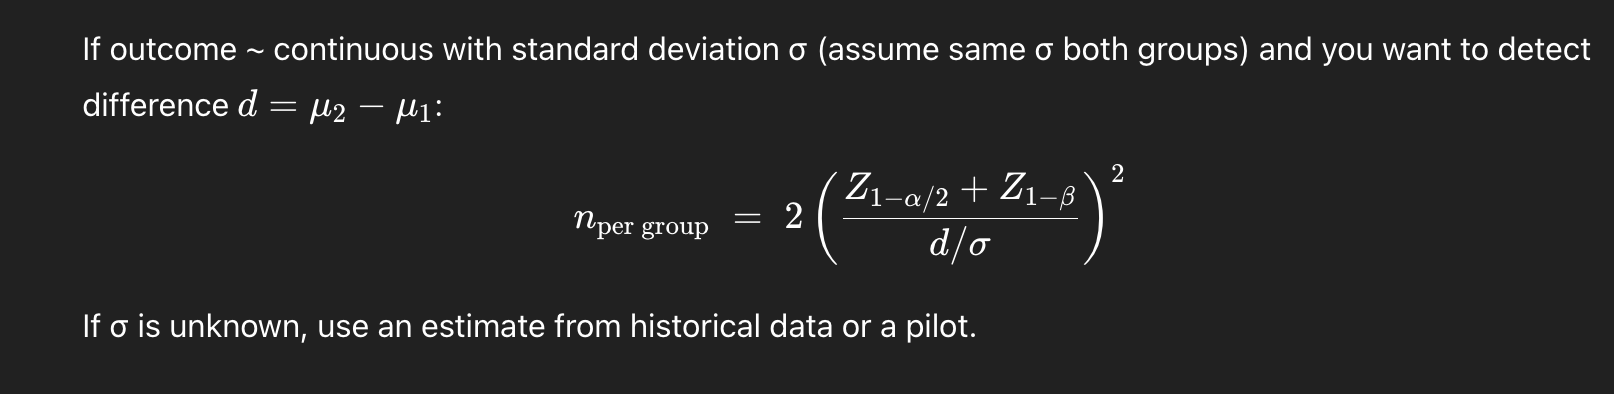

for continues outcome we use the second formula which takes input sd difference as d.

In [9]:
def requried_sample(a,b,alpha=0.05,beta=0.20):
  p1 = sum(a)/len(a)
  p2 = sum(b)/len(b)
  d = p2-p1
  # ppf-percentage point function, it is the inverse of cdf,it tell us the ci of the normal distribution
  z_alpha = norm.ppf(1-alpha/2)
  z_beta = norm.ppf(1-beta)
  p_avg = (p1+p2)/2
  nums = z_alpha*np.sqrt(2*p_avg*(1-p_avg)) + z_beta*np.sqrt(p1*(1-p1)+p2*(1-p2))
  den = d**2
  sample_size = nums/den
  return sample_size

In [10]:
np.random.seed(42)
a = np.random.binomial(1,0.20,1000)
b = np.random.binomial(1,0.22,1000)
sample_size = requried_sample(a,b)

In [11]:
print('number of samples required for each sample to find the true significance is ',sample_size)

number of samples required for each sample to find the true significance is  2068.7291720613225


In [12]:
np.arange(200,5001,200)

array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000, 2200,
       2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400,
       4600, 4800, 5000])

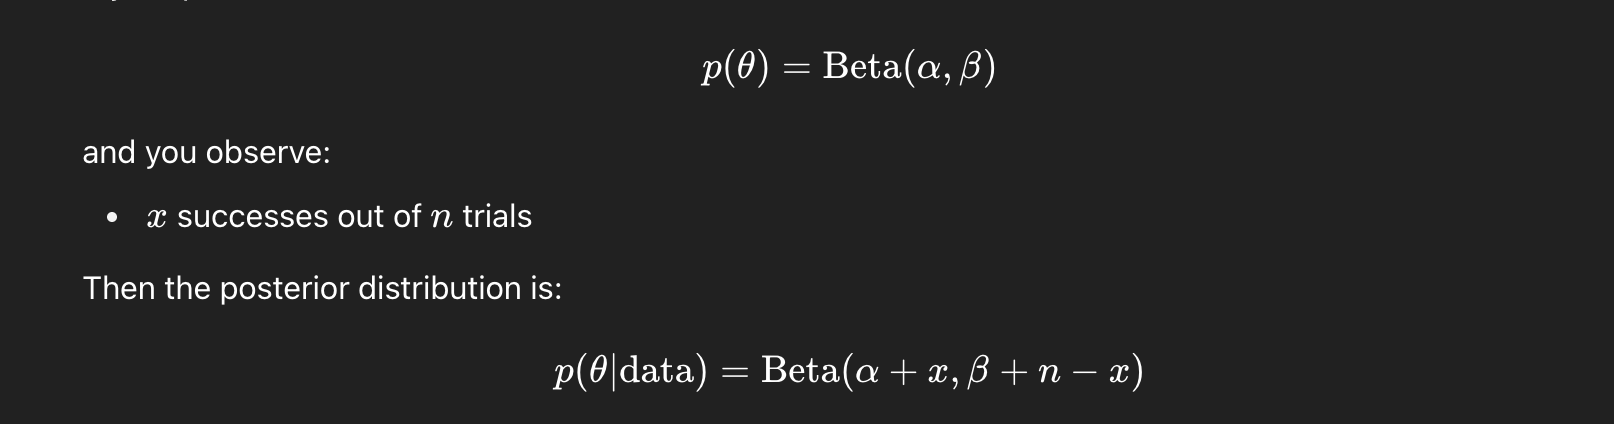

here alpha and beta will be 1 (uniform distribution initially)

In [13]:
na = 1000
nb = 1000
pa = 20 # a - no of success
pb = 25 # b - no of success
alpha,beta = 1,1
a_prob = np.random.beta(alpha+na,beta+(na-pa),1000000)
b_prob = np.random.beta(alpha+nb,beta+(nb-pb),1000000)

# is b > a
b_better_prob = np.mean(b_prob > a_prob)
print(b_better_prob)

0.532728


no matter how much we run the simulation the b site is always converges around 0.53, so which mean site b is 53% better thann site A.

In [14]:
na = 1000
nb = 1000
pa = 20 # successes for A
pb = 25 # successes for B

# Calculate failures
failures_a = na - pa
failures_b = nb - pb

alpha, beta = 1, 1 # Uniform prior

# alpha + successes, beta + failures
a_prob = np.random.beta(alpha + pa, beta + failures_a, 1000000)
b_prob = np.random.beta(alpha + pb, beta + failures_b, 1000000)

# how much percentage b > a
b_better_prob = np.mean(b_prob > a_prob)
print(b_better_prob)

0.772418
